In [1]:
import numpy as np
import seaborn as sns
import scanpy as sc
import moscot as mt
import scotty as sct

In [2]:
%load_ext autoreload
%autoreload 2

# Overview

This notebook will highlight some of the trajectory analysis tools included in `scotty-tools`, including 
:

* "Fate flow" visualization
* Fate entropy analysis (TODO)
* Trajectory integration and clustering

# Dataset

For this tutorial, we will use a dataset of differentiating hematopoietic stem cells collected at several timepoints from a single donor. Each cell has been labeled with its cell type based on prior biological knowledge (i.e. marker gene expression), giving us a ground-truth against which to compare our trajectory analysis.

In [3]:
adata = mt.datasets.hspc()
adata

AnnData object with n_obs × n_vars = 4000 × 2000
    obs: 'day', 'donor', 'cell_type', 'technology', 'n_genes'
    var: 'n_cells', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'cell_type_colors', 'hvg', 'neighbors', 'neighbors_atac', 'pca', 'umap'
    obsm: 'X_lsi', 'X_pca', 'X_umap_ATAC', 'X_umap_GEX', 'peaks_tfidf'
    varm: 'PCs'
    obsp: 'connectivities', 'distances', 'neighbors_atac_connectivities', 'neighbors_atac_distances'

Although the dataset includes both single-cell RNA and ATAC sequencing, we will only use the RNA gene expression (GEX) data for simplicity.

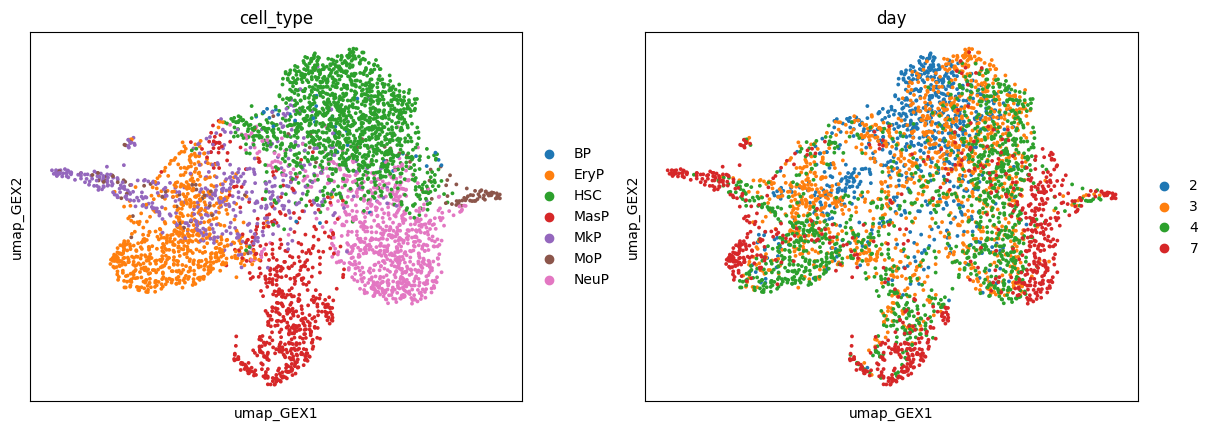

In [24]:
sc.pl.embedding(adata, basis='umap_GEX', color=['cell_type', 'day'])

We see that the cells form clusters based on cell type, and that each cell type is stratified by timepoint as well.

## Fit trajectories using `moscot`

First, we will fit optimal transport (OT) trajectories using the computational machinery built into `moscot`. In addition, we will check for outliers in predicted growth rates, and clip them to prevent trajectory collapse.

We compute the prior growth rates from proliferation and apoptosis gene set scores and apply a scaling factor, $\sigma$, that determines how heavily the raw gene set scores impact the prior growth rates, via the formula:

$$g = \exp\left[\frac{\left(y_\text{prolif.} - y_\text{apop.}\right)\left(t_\text{target} - t_\text{source}\right)}{\sigma}\right]$$

In [6]:
ot_model = sct.models.trajectory.MoscotModel.from_adata(adata)
ot_model.score_genes_for_marginals(gene_set_proliferation='human', gene_set_apoptosis='human')
ot_model.prepare(time_key='day', marginal_kwargs={'scaling': 2})

       'BUB1', 'CASP8AP2', 'CBX5', 'CCNB2', 'CCNE2', 'CDC20', 'CDC25C',
       'CDC45', 'CDC6', 'CDCA2', 'CDCA3', 'CDCA7', 'CDCA8', 'CDK1', 'CENPA',
       'CENPF', 'CHAF1B', 'CKAP2', 'CKAP2L', 'CKAP5', 'CKS1B', 'CKS2', 'CLSPN',
       'CTCF', 'DLGAP5', 'DSCC1', 'DTL', 'E2F8', 'ECT2', 'EXO1', 'FAM64A',
       'FEN1', 'G2E3', 'GAS2L3', 'GINS2', 'GMNN', 'GTSE1', 'HELLS', 'HJURP',
       'HMGB2', 'HMMR', 'HN1', 'KIF11', 'KIF20B', 'KIF23', 'KIF2C', 'LBR',
       'MCM2', 'MCM4', 'MCM5', 'MCM6', 'MLF1IP', 'MSH2', 'NASP', 'NCAPD2',
       'NDC80', 'NEK2', 'NUF2', 'NUSAP1', 'PCNA', 'POLA1', 'POLD3', 'PRIM1',
       'PSRC1', 'RAD51', 'RAD51AP1', 'RANGAP1', 'RFC2', 'RPA2', 'RRM1', 'RRM2',
       'SLBP', 'SMC4', 'TACC3', 'TIPIN', 'TMPO', 'TOP2A', 'TPX2', 'TTK',
       'TUBB4B', 'TYMS', 'UBR7', 'UHRF1', 'UNG', 'USP1', 'WDR76'],
      dtype='object')
       'BCAP31', 'BCL10',
       ...
       'TIMP2', 'TNF', 'TNFRSF12A', 'TNFSF10', 'TOP2A', 'TSPO', 'TXNIP',
       'VDAC2', 'WEE1', 'XIAP'],
      d

Let's look at the prior growth rates more closely:

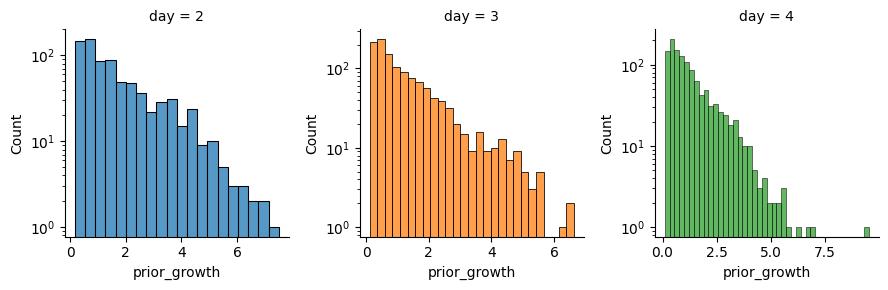

In [7]:
adata.obs['prior_growth'] = ot_model.moscot_model.prior_growth_rates
df_growth = adata.obs[['day', 'prior_growth']]
df_growth = df_growth.loc[~df_growth['prior_growth'].isna()]
df_growth['day'] = df_growth['day'].cat.remove_unused_categories()

g = sns.FacetGrid(df_growth, col='day', hue='day', sharex=False, sharey=False)
g.map_dataframe(sns.histplot, x='prior_growth')
g.set(yscale='log')

There are a few outliers at each source day with high prior growth rates. Due to the exponential population model, these can exert a high amount of influence on the trajectory when there are large time gaps. In the extreme, this may collapse the entirety of the trajectory onto a single cell. To avoid this undesirable behavior, we can clip the growth rates for each timepoint at an upper threshold of our choosing.

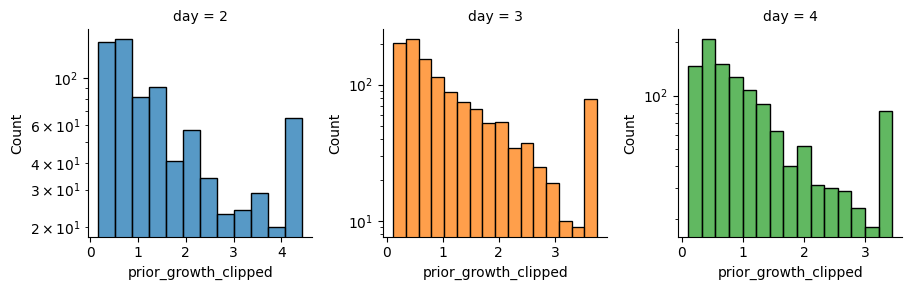

In [8]:
ot_model.clip_growth_rates(upper_quantile=0.95)

adata.obs['prior_growth_clipped'] = ot_model.moscot_model.prior_growth_rates
df_growth = adata.obs[['day', 'prior_growth_clipped']]
df_growth = df_growth.loc[~df_growth['prior_growth_clipped'].isna()]
df_growth['day'] = df_growth['day'].cat.remove_unused_categories()

g = sns.FacetGrid(df_growth, col='day', hue='day', sharex=False, sharey=False)
g.map_dataframe(sns.histplot, x='prior_growth_clipped')
g.set(yscale='log')

Clipping the growth rates effectively creates a larger pool of ancestors at each source timepoint.

Now, we can solve the OT problem.

In [9]:
ot_model.solve(epsilon=0.01, tau_a=0.95, tau_b=0.9995, scale_cost='mean')

INFO     Solving `3` problems                                                                                      
INFO     Solving problem BirthDeathProblem[stage='prepared', shape=(766, 1235)].                                   
INFO     Solving problem BirthDeathProblem[stage='prepared', shape=(1235, 1201)].                                  
INFO     Solving problem BirthDeathProblem[stage='prepared', shape=(1201, 798)].                                   


Let's visualize how the (clipped) prior growth rates compare to the posterior growth rates after fitting:

/home/alpaca/miniforge3/envs/scotty-tools-dev/lib/python3.12/site-packages/moscot/problems/time/_mixins.py:452: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  return pd.concat([df_1, df_2], verify_integrity=True)


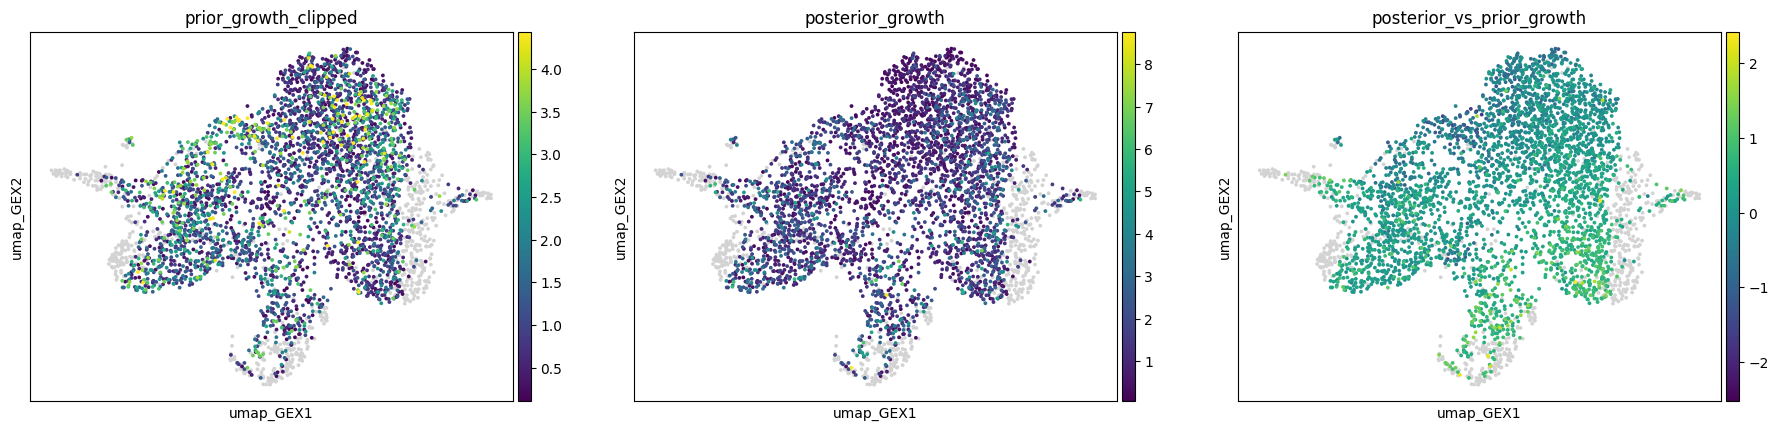

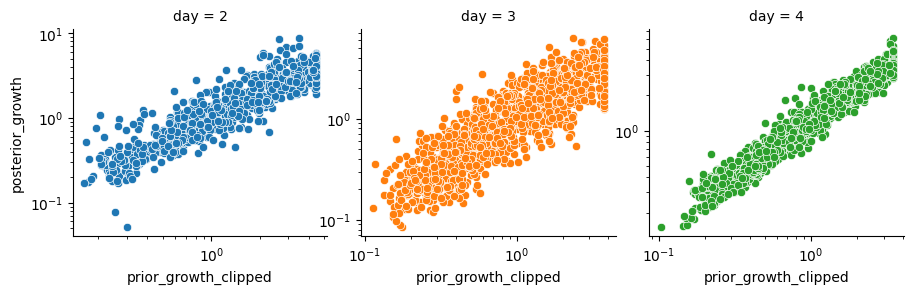

In [10]:
adata.obs['posterior_growth'] = ot_model.moscot_model.posterior_growth_rates
adata.obs['posterior_vs_prior_growth'] = np.log2(adata.obs['posterior_growth'] / adata.obs['prior_growth_clipped'])

sc.pl.embedding(adata, basis='umap_GEX', color=['prior_growth_clipped', 'posterior_growth', 'posterior_vs_prior_growth'])

df_growth = adata.obs[['day', 'prior_growth_clipped', 'posterior_growth']]
df_growth = df_growth.loc[~df_growth['prior_growth_clipped'].isna()]
df_growth['day'] = df_growth['day'].cat.remove_unused_categories()

g = sns.FacetGrid(df_growth, col='day', hue='day', sharey=False, sharex=False)
g.map_dataframe(sns.scatterplot, x='prior_growth_clipped', y='posterior_growth')
g.set(xscale='log', yscale='log')

We see good agreement between the prior and posterior growth rates.

## Plot fate-flow Sankeys using `scotty-tools`

We can visualize the differentiation relationships between cell types over time by using a Sankey diagram to summarize "fate flows." This visualization represents the probabilities of cell transitions at consecutive timepoints through the sizes of the flows that connect clusters. We can further represent population expansion and contraction resulting from the aggregate effects of proliferation and apoptosis through the changing sizes of flows between timepoints.

Let's look at fate flows between labeled cell types under OT:

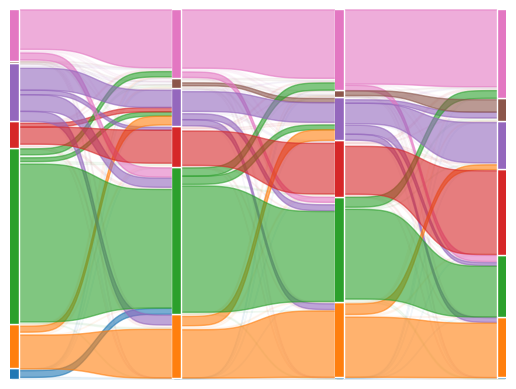

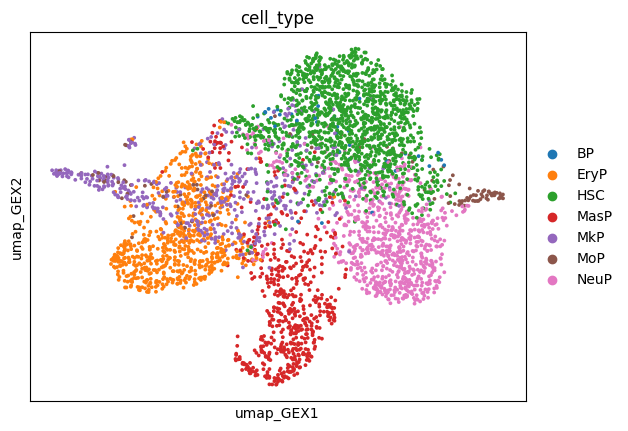

In [11]:
sankey_cell_type = sct.plotting.Sankey(ot_model, adata.obs['cell_type'])
_ = sankey_cell_type.plot_all_transitions(min_flow_threshold=0.01)
sc.pl.embedding(adata, basis='umap_GEX', color='cell_type')

## Integrate timepoints using `scotty-tools`

For timecourse datasets, we may be interested in finding time-invariant features of lineages. For example, we may want to find genes that stably identify lineages over time, rather than those which are transiently expressed. Or, we may want to cluster cells into distinct lineages based on their predicted trajectories.

We can leverage our OT model to integrate across timepoints using a trajectory kernel mean embedding (TKME). This effectively integrates cells from distinct timepoints according to the OT model, by projecting cells into an embedding space shared across timepoints.

In [ ]:
tkme = sct.models.featurize.TrajectoryKMEFeaturizer()
X_tkme = tkme.fit_transform(ot_model, adata)

We can treat the TKME features like any other transformation, adding them to our `adata` and performing dimensionality reduction.

In [ ]:
adata.obsm['X_tkme'] = X_tkme[adata.obs_names].X
sc.pp.pca(adata, obsm='X_tkme', key_added='X_pca_tkme')
sc.pp.neighbors(adata, use_rep='X_pca_tkme', key_added='neighbors_tkme', n_neighbors=30)
sc.tl.umap(adata, neighbors_key='neighbors_tkme', key_added='X_umap_TKME')

In [ ]:
sc.pl.embedding(adata, basis='umap_TKME', color=['day', 'cell_type'])

We can see that the TKME featurization effectively integrated cells across timepoints, while keeping distinct cell type lineages intact.

## Cluster trajectories using `scotty-tools`

One use for whole-trajectory embeddings is to perform clustering to identify major cell lineages. We will compare the results of Leiden clustering on both gene expression (GEX) as well as TKME to see how their trajectories differ.

/tmp/ipykernel_1036604/4216407165.py:1: FutureWarning: The `igraph` implementation of leiden clustering is *orders of magnitude faster*. Set the flavor argument to (and install if needed) 'igraph' to use it.
In the future, the default backend for leiden will be igraph instead of leidenalg. To achieve the future defaults please pass: `flavor='igraph'` and `n_iterations=2`. `directed` must also be `False` to work with igraph’s implementation.
  sc.tl.leiden(adata, resolution=1, neighbors_key='neighbors', key_added='leiden_GEX')
/tmp/ipykernel_1036604/4216407165.py:2: FutureWarning: The `igraph` implementation of leiden clustering is *orders of magnitude faster*. Set the flavor argument to (and install if needed) 'igraph' to use it.
In the future, the default backend for leiden will be igraph instead of leidenalg. To achieve the future defaults please pass: `flavor='igraph'` and `n_iterations=2`. `directed` must also be `False` to work with igraph’s implementation.
  sc.tl.leiden(adata, r

Clusters visualized in GEX UMAP space


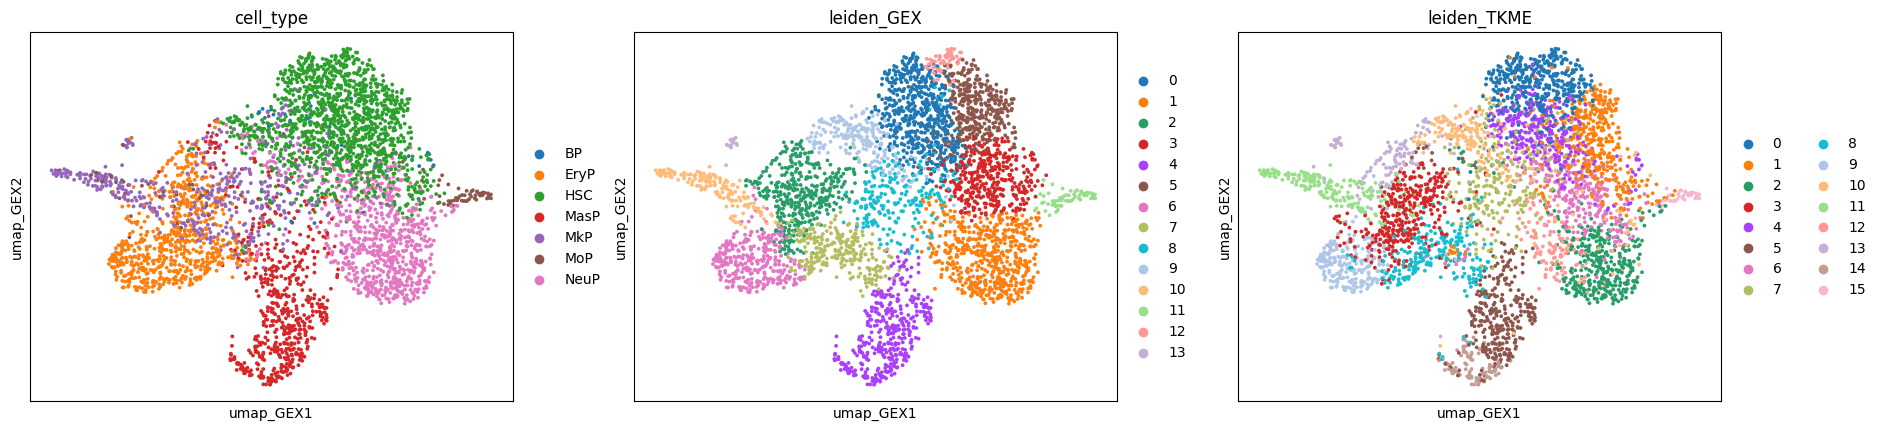

Clusters visualized in TKME UMAP space


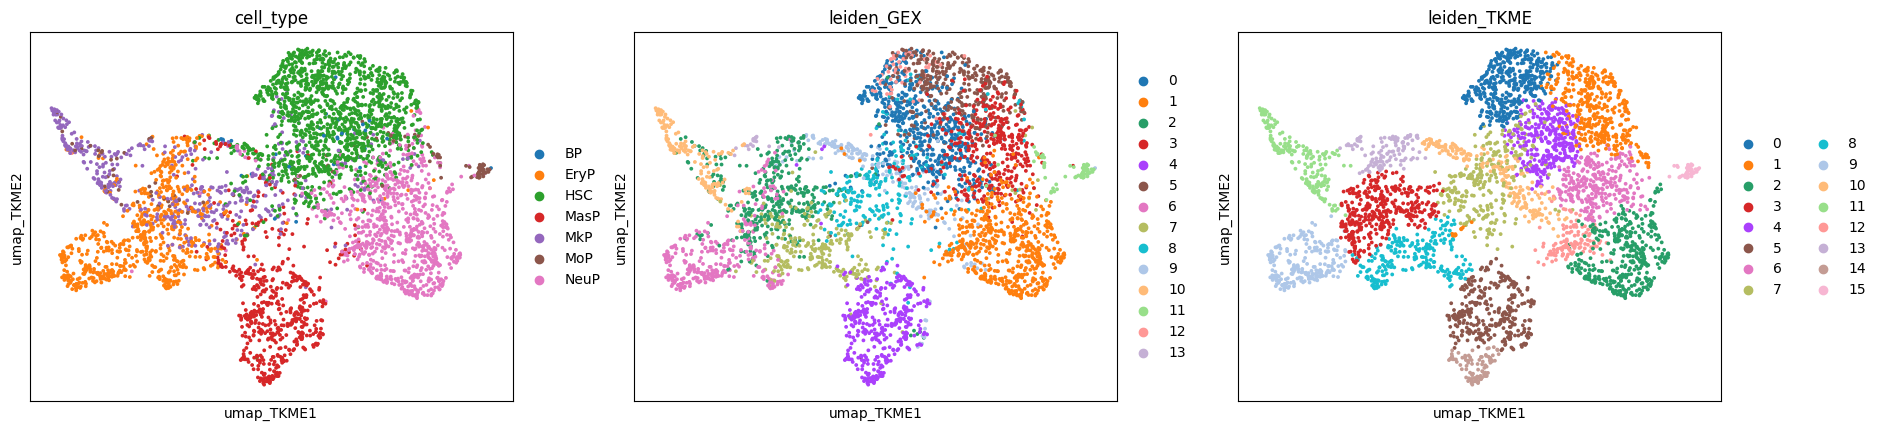

In [21]:
sc.tl.leiden(adata, resolution=1, neighbors_key='neighbors', key_added='leiden_GEX')
sc.tl.leiden(adata, resolution=1, neighbors_key='neighbors_tkme', key_added='leiden_TKME')

print('Clusters visualized in GEX UMAP space:')
sc.pl.embedding(adata, basis='umap_GEX', color=['cell_type', 'leiden_GEX', 'leiden_TKME'])
print('Clusters visualized in TKME UMAP space:')
sc.pl.embedding(adata, basis='umap_TKME', color=['cell_type', 'leiden_GEX', 'leiden_TKME'])

Both sets of clusters correspond quite well to the ground-truth cell types. This makes sense, since the gene expression information alone already does a good job of encoding lineage in this dataset without being confounded by time. 

However, we can still see that the trajectory clusters provide us with a smoother picture of the differentiation process by comparing fate flows for both sets of clusters:

GEX clusters:


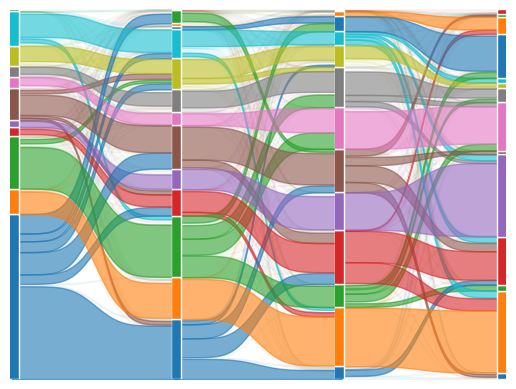

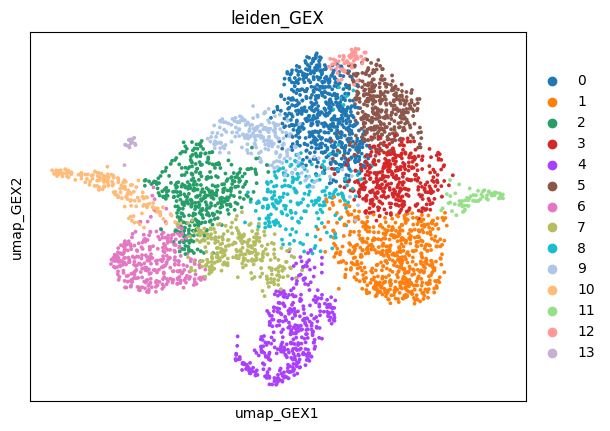

In [22]:
print('GEX clusters:')
sankey_leiden_gex = sct.plotting.Sankey(ot_model, adata.obs['leiden_GEX'])
_ = sankey_leiden_gex.plot_all_transitions(min_flow_threshold=0.01)
sc.pl.embedding(adata, basis='umap_GEX', color='leiden_GEX')

TKME clusters:


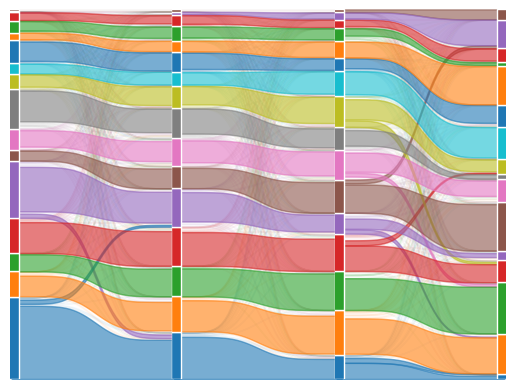

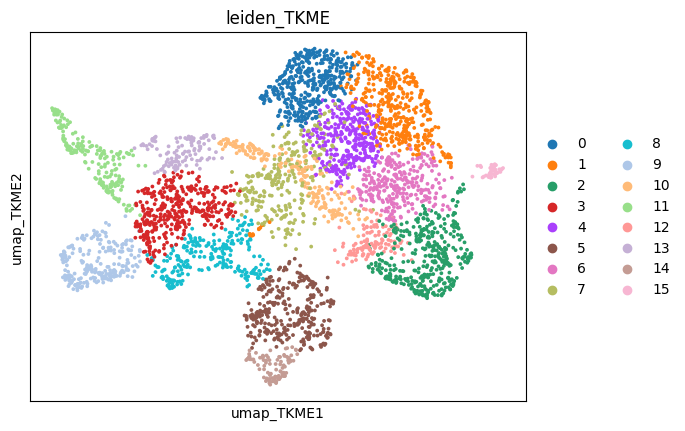

In [23]:
print('TKME clusters:')
sankey_leiden_tkme = sct.plotting.Sankey(ot_model, adata.obs['leiden_TKME'])
_ = sankey_leiden_tkme.plot_all_transitions(min_flow_threshold=0.01)
sc.pl.embedding(adata, basis='umap_TKME', color='leiden_TKME')

The trajectory clusters have much smoother flows, forming streamlines that cross-section the trajectory into distinct lineages.